In [1]:
import gym
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from scouting_gym.tasks.scouting_discrete_task import ScoutingDiscreteTask

Instructions for updating:
non-resource variables are not supported in the long term
None


## Register Environment

In [2]:
env = gym.make('Scouting-v0')

print("Observation Space: {}".format(env.observation_space))
print("Action Space: {}".format(env.action_space))

[ERROR] [1613731558.968717, 0.000000]: NOT Initialising Simulation Physics Parameters
[WARN] [1613731558.972389, 0.000000]: Start Init ControllersConnection
[WARN] [1613731558.973123, 0.000000]: END Init ControllersConnection


Observation Space: Box(0.0, 1.0, (84, 84, 4), float32)
Action Space: Discrete(3)


## Check Environment State

0.0
1.0


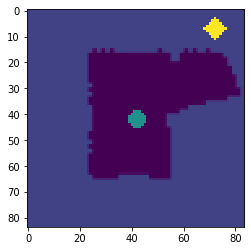

In [3]:
obs = env.reset()
for _ in range(1):
    obs, _, _, _ = env.step(action=2)
plt.imshow(obs[:, :, 0])
print(obs.min())
print(obs.max())

## Ray Configs

In [4]:
config = {
    "env": ScoutingDiscreteTask,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    "num_gpus": 1,
    "num_workers": 1
}

stop = {
    "episodes_total": 8000,
}

In [5]:
ray.init()

2021-02-19 11:46:02,347	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.178.60',
 'raylet_ip_address': '192.168.178.60',
 'redis_address': '192.168.178.60:6379',
 'object_store_address': '/tmp/ray/session_2021-02-19_11-46-01_840931_13830/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-19_11-46-01_840931_13830/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-02-19_11-46-01_840931_13830',
 'metrics_export_port': 39522,
 'node_id': '56ad4d6c500cc5acca027fdb6d5df9e3f67bef72'}

## Train

In [6]:
def train(stop_criteria, config, restorepath):
    """
    Train an RLlib PPO agent using tune until any of the configured stopping criteria is met.
    :param stop_criteria: Dict with stopping criteria.
        See https://docs.ray.io/en/latest/tune/api_docs/execution.html#tune-run
    :return: Return the path to the saved agent (checkpoint) and tune's ExperimentAnalysis object
        See https://docs.ray.io/en/latest/tune/api_docs/analysis.html#experimentanalysis-tune-experimentanalysis
    """
    analysis = ray.tune.run(PPOTrainer, config=config,
                            stop=stop_criteria,
                            checkpoint_freq=1,
                            checkpoint_at_end=True,
                            restore=restorepath)
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean',
                                                       )
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    return checkpoint_path, analysis

def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent

def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

def test_traj(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    positions = []
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        positions.append(info['position'])
        episode_reward += reward

    return episode_reward, positions

In [7]:
checkpoint_path, analysis = train(stop_criteria=stop,
                                  config=config,
                                  restorepath='/home/dschori/ray_results/'
                                              'PPO_2021-02-09_17-09-27/' \
                  'PPO_ScoutingDiscreteTask_2f1df_00000_0_2021-02-09_17-09-27/' \
                  'checkpoint_201/checkpoint-201')

2021-02-09 21:37:29,996	INFO trainable.py:72 -- Checkpoint size is 24109446 bytes
(pid=3339694) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=3339694) Instructions for updating:
(pid=3339694) non-resource variables are not supported in the long term
(pid=3339694) 2021-02-09 21:37:33,050	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=3339694) 2021-02-09 21:37:33,050	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=3339696) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in

Trial name,status,loc
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,


(pid=3339694) None
(pid=3339696) None
Result for PPO_ScoutingDiscreteTask_a0e0c_00000:
  custom_metrics: {}
  date: 2021-02-09_21-46-53
  done: false
  episode_len_mean: 124.54838709677419
  episode_reward_max: 118.38444732621318
  episode_reward_mean: 76.36165389001842
  episode_reward_min: -96.52579843274803
  episodes_this_iter: 31
  episodes_total: 5030
  experiment_id: cbe2f70fbfd44ae186b60705bb56fcbb
  hostname: workstation
  info:
    learner:
      default_policy:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 0.36332884430885315
        entropy_coeff: 0.0
        kl: 0.042046040296554565
        model: {}
        policy_loss: -0.10939115285873413
        total_loss: 634.2264404296875
        vf_explained_var: 0.745877742767334
        vf_loss: 634.3275146484375
    num_steps_sampled: 808000
    num_steps_trained: 808000
  iterations_since_restore: 1
  node_ip: 192.168.178.60
  num_healthy_workers: 1
  off_policy_estimator: {}
 

Trial name,status,loc
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,202,110399,808000,76.3617,118.384,-96.5258,124.548


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,203,110936,812000,68.5295,118.392,-104.88,122.938


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,204,111460,816000,64.1024,118.392,-106.574,117.39


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,205,111986,820000,66.0876,118.4,-106.574,123.43


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,206,112515,824000,61.681,118.4,-106.574,123.84


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,207,113035,828000,60.0617,118.4,-106.341,128.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,208,113560,832000,62.083,118.398,-106.568,126.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,209,114086,836000,70.5095,118.399,-106.895,128.89


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,210,114602,840000,70.3951,118.399,-106.895,131.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,211,115151,844000,67.8485,118.399,-106.895,134.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,212,115683,848000,68.3023,118.399,-106.895,136.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,213,116201,852000,66.1529,118.398,-106.496,128.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,214,116722,856000,64.2617,118.398,-106.496,132.11


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,215,117283,860000,51.7821,118.393,-106.496,125.82


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,216,117809,864000,49.6242,118.393,-106.403,131.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,217,118330,868000,58.0102,118.393,-106.403,136.06


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,218,118856,872000,64.4976,118.385,-106.403,134.66


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,219,119381,876000,55.8078,118.398,-106.403,126.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,220,119899,880000,64.5794,118.398,-104.81,135.22


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,221,120425,884000,58.169,118.398,-104.81,128.84


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,222,120949,888000,68.4911,118.397,-105.11,133.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,223,121465,892000,58.2901,118.397,-105.11,135.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,224,121987,896000,66.8077,118.396,-105.11,134.75


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,225,122511,900000,66.8536,118.396,-101.694,136.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,226,123043,904000,66.9727,118.379,-104.826,131.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,227,123560,908000,74.9086,118.397,-106.342,136.18


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,228,124093,912000,68.5897,118.397,-106.342,129.27


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,229,124617,916000,64.4958,118.398,-106.342,127.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,230,125145,920000,60.6352,118.398,-105.966,121.54


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,231,125673,924000,62.6774,118.398,-107.449,124.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,232,126194,928000,68.5921,118.4,-107.449,120.3


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,233,126721,932000,68.3084,118.4,-107.449,122.37


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,234,127243,936000,64.1759,118.4,-105.882,121.68


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,235,127771,940000,66.1428,118.398,-105.882,125.43


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,236,128301,944000,68.6851,118.398,-105.703,118.95


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,237,128835,948000,77.2841,118.399,-105.703,119.48


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,238,129356,952000,79.6432,118.399,-100.912,127.35


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,239,129888,956000,90.0024,118.399,-105.06,134.81


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,240,130414,960000,87.7144,118.399,-105.06,131.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,241,130940,964000,89.7627,118.399,-105.06,133.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,242,131469,968000,91.8603,118.393,-105.06,127.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,243,132000,972000,89.8074,118.393,-107.419,129.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,244,132529,976000,80.6841,118.399,-107.419,123.15


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,245,133055,980000,67.9097,118.399,-107.419,118.76


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,246,133585,984000,68.1261,118.399,-106.019,120.5


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,247,134110,988000,75.1127,118.398,-105.147,123.29


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,248,134637,992000,79.459,118.4,-105.147,127.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,249,135160,996000,81.1533,118.4,-115.518,132.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,250,135683,1000000,80.8558,118.4,-115.518,134.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,251,136210,1004000,81.0557,118.4,-115.518,133.8


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,252,136738,1008000,85.8326,118.4,-106.378,129.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,253,137265,1012000,77.6983,118.4,-106.372,124.71


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,254,137796,1016000,81.7872,118.4,-106.372,132


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,255,138316,1020000,83.6374,118.399,-106.372,135.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,256,138835,1024000,81.7584,118.399,-102.873,137.62


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,257,139361,1028000,83.7295,118.399,-99.0582,133.93


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,258,139885,1032000,87.8305,118.396,-99.0582,134.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,259,140411,1036000,85.6057,118.396,-105.108,128.24


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,260,140979,1040000,83.6018,118.396,-105.108,129.05


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,261,141506,1044000,79.3975,118.386,-105.108,130.17


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,262,142035,1048000,79.2441,118.398,-105.108,129.49


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,263,142558,1052000,83.6207,118.398,-104.85,134.7


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,264,143088,1056000,85.7901,118.398,-98.8285,132.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,265,143658,1060000,81.4712,118.398,-106.382,133.12


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,266,144213,1064000,85.3723,118.393,-106.382,132.45


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,267,144738,1068000,89.5405,118.391,-106.382,127.94


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,268,145268,1072000,89.6042,118.391,-106.382,136.71


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,269,145799,1076000,87.921,118.391,-99.4603,134.34


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,270,146330,1080000,77.2294,118.395,-105.88,131.06


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,271,146860,1084000,81.1933,118.395,-105.88,129.68


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,272,147387,1088000,80.9832,118.395,-105.88,130.01


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,273,147909,1092000,85.1782,118.385,-105.88,130.98


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,274,148443,1096000,79.2294,118.385,-105.332,131.71


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,275,148975,1100000,79.0947,118.385,-105.332,130.31


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,276,149512,1104000,83.3583,118.389,-105.332,132.46


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,277,150068,1108000,87.531,118.396,-105.332,135.97


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,278,150613,1112000,79.1456,118.396,-105.523,136.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,279,151143,1116000,77.2501,118.398,-105.523,137.55


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,280,151679,1120000,75.1753,118.398,-105.523,133.02


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,281,152207,1124000,89.818,118.398,-106.18,136.16


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,282,152742,1128000,79.1579,118.389,-106.18,129.56


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,283,153275,1132000,68.3819,118.373,-106.18,131.38


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,284,153808,1136000,61.8383,118.398,-105.69,127.44


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,285,154343,1140000,74.5173,118.398,-105.69,130.14


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,286,154884,1144000,82.9595,118.398,-105.69,136.03


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,287,155428,1148000,83.5107,118.398,-105.632,132.52


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,288,155987,1152000,73.2483,118.399,-105.632,127.72


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,289,156550,1156000,66.7098,118.399,-112.4,117.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,290,157092,1160000,66.2096,118.399,-112.4,112.28


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,291,157644,1164000,68.4434,118.389,-112.4,118.4


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,292,158207,1168000,79.2051,118.389,-105.577,122.47


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,293,158745,1172000,83.7224,118.389,-106.343,130.33


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,294,159284,1176000,72.9546,118.387,-106.343,126.19


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,295,159813,1180000,66.4533,118.395,-106.343,127.57


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,296,160346,1184000,68.463,118.395,-104.556,124.78


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,297,160879,1188000,74.795,118.395,-104.556,124.59


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,RUNNING,192.168.178.60:3339694,298,161414,1192000,81.0927,118.396,-106.638,121.96


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_ScoutingDiscreteTask_a0e0c_00000,TERMINATED,,298,161414,1192000,81.0927,118.396,-106.638,121.96


## Restore Agent for Testing:

In [9]:
checkpoint_nr = 164
checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                  'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                  'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
agent = load(checkpoint_path=checkpoint_path, config=config)

(pid=9122) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=9122) Instructions for updating:
(pid=9122) non-resource variables are not supported in the long term
(pid=9122) [ERROR] [1613730491.594615, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=9122) [WARN] [1613730491.597638, 0.000000]: Start Init ControllersConnection
(pid=9122) [WARN] [1613730491.598538, 0.000000]: END Init ControllersConnection
2021-02-19 11:28:17,413	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-02-19 11:28:17,569	INFO trainable.py:328 -- Restored on 192.168.178.60 from checkpoint: /home/dschori/ray_results/PPO_2021-02-17_15-27-03/PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/checkpoint_164/checkpoint-164
2021-02-19 11:28:17,570	INFO trainable.py:336 -- Current state

(pid=9122) None


## Test Run

In [10]:
import time
time_now = time.time()
while True:
    episode_reward = test_traj(agent=agent, env=env)
    if time.time() - time_now > 10:
        break

(-4.163545654589269, -4.685642251000309)
(-4.163660477185073, -4.622855484191511)
(-4.15834685476084, -4.542582733687483)
(-4.146941683532642, -4.457256055048216)
(-4.126270718285108, -4.369402592302591)
(-4.102308745545383, -4.301763219536582)
(-4.0695191542337055, -4.233968972539555)
(-4.01467702615248, -4.141141622159252)
(-3.969922633094214, -4.073711466240663)
(-3.918750584542717, -4.00031087356683)
(-3.85966770830398, -3.919659110174714)
(-3.8111553220260346, -3.854636078567108)
(-3.7601454854127825, -3.7889604073739243)
(-3.7117794355632867, -3.7347356628531263)
(-3.6518635516356137, -3.6790648837270297)
(-3.586026610014752, -3.629353538660203)
(-3.51805562068295, -3.5849551160682673)
(-3.441997069826733, -3.5395191453608588)
(-3.359005931365135, -3.4929079894255732)
(-3.2616174411781365, -3.4398272545298445)
(-3.1846638700169865, -3.3993599678941746)
(-3.0850206572909826, -3.3476143631966377)
(-3.014374009703257, -3.3127820610128706)
(-2.9427695514517787, -3.282133382645069)
(-

In [46]:
trajectories = {}
runs = 15
checkpoints = [1, 5, 10, 40, 80, 164]
for checkpoint in checkpoints:
#for checkpoint in [1, 10]:
    checkpoint_nr = checkpoint
    checkpoint_path = '/home/dschori/ray_results/PPO_2021-02-17_15-27-03/' \
                      'PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/' \
                      'checkpoint_{}/checkpoint-{}'.format(checkpoint_nr, checkpoint_nr)
    agent = load(checkpoint_path=checkpoint_path, config=config)
    trajectories['checkpoint_traj_{}'.format(checkpoint)] = {}
    trajectories['checkpoint_success_{}'.format(checkpoint)] = {}
    for i in range(runs):
        episode_reward, positions = test_traj(agent=agent, env=env)
        trajectories['checkpoint_traj_{}'.format(checkpoint)]['run{}'.format(i)] = positions
        if episode_reward > 0:
           trajectories['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i)] = True
        else:
           trajectories['checkpoint_success_{}'.format(checkpoint)]['run{}'.format(i)] = False

(pid=90244) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=90244) Instructions for updating:
(pid=90244) non-resource variables are not supported in the long term
(pid=90244) [ERROR] [1613740302.894058, 0.000000]: NOT Initialising Simulation Physics Parameters
(pid=90244) [WARN] [1613740302.897071, 0.000000]: Start Init ControllersConnection
(pid=90244) [WARN] [1613740302.897807, 0.000000]: END Init ControllersConnection
2021-02-19 14:11:48,913	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-02-19 14:11:49,042	INFO trainable.py:328 -- Restored on 192.168.178.60 from checkpoint: /home/dschori/ray_results/PPO_2021-02-17_15-27-03/PPO_ScoutingDiscreteTask_34787_00000_0_2021-02-17_15-27-03/checkpoint_1/checkpoint-1
2021-02-19 14:11:49,043	INFO trainable.py:336 -- Current sta

(pid=90244) None
(pid=93239) None
(pid=96555) None
(pid=101997) None
(pid=109774) None
(pid=120784) None


Episode: 30, Success Rate:       0.00%
Episode: 152, Success Rate:       0.00%
Episode: 152, Success Rate:      13.33%
Episode: 305, Success Rate:      20.00%
Episode: 305, Success Rate:      46.67%
Episode: 1221, Success Rate:      73.33%


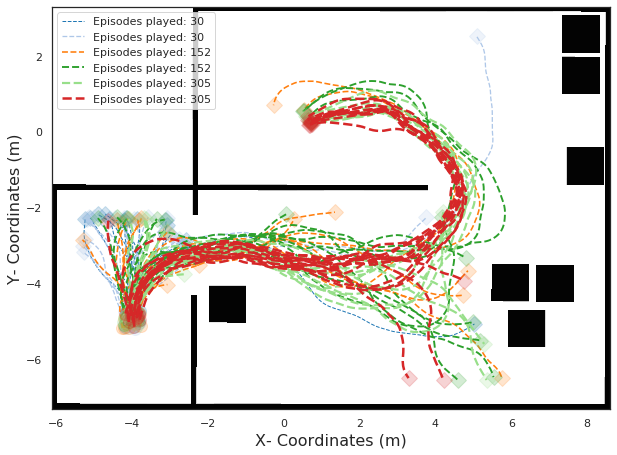

In [64]:
import seaborn as sns
import numpy as np
sns.set_theme(style="white")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

img = plt.imread("background_env3.png")
ax.imshow(img, extent=[-6.1, 8.6, -7.3, 3.3])

ax.set_xlabel('X- Coordinates (m)', fontsize=16)
ax.set_ylabel('Y- Coordinates (m)', fontsize=16)

ax.set_xlim([-6.1, 8.6])
ax.set_ylim([-7.3, 3.3])

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(150)

thickness = 1.0
i = 0
for checkpoint_key, checkpoint_value in trajectories.items():
    if 'success' in checkpoint_key:
        results = 0.0
        for _, success in checkpoint_value.items():
            results += int(success)
        print('Episode: {}, Success Rate: {:10.2f}%'.format(int(checkpoints[i//2]*30.5305), (results/15.)*100.))
        continue
    line = None
    for run_key, run_value in checkpoint_value.items():
        x_s = [e[0] for e in run_value]
        y_s = [e[1] for e in run_value]
        starting_point = (x_s[0], y_s[0])
        ending_point = (x_s[-1], y_s[-1])
        ax.plot(*starting_point, marker='o', markersize=12, c=cmap(i * 10), alpha=0.2)
        ax.plot(*ending_point, marker='D', markersize=12, c=cmap(i * 10), alpha=0.2)
        line, = ax.plot(x_s, y_s, linestyle='dashed', linewidth=thickness, c=cmap(i * 10))
    line.set_label('Episodes played: {}'.format(int(checkpoints[i//2]*30.5305)))
    thickness += 0.3
    i+=1

ax.legend()
plt.savefig('training_traj.png', dpi=300)

In [ ]:
x=-6.1, 8.6
y=-7.3, 3.3
